# Double Slit Experiment Solver.

This page contains the code to numerically solve the Schrodinger equation for a particle of mass $m=1$ and in naturalized units, i.e $\hbar = 1$. In particular, we have the partial differential equation given by

$i\frac{\partial \psi(x,y,t)}{\partial t} = -\frac{\partial^2 \psi(x,y,t)}{\partial x^2} - \frac{\partial^2 \psi(x,y,t)}{\partial y^2} + V(x,y)\psi(x,y,t)$

here, $\psi(x,y,t)$ is the wave function of the particle, and $V(x,y)$ is the potential field. We run the simulation in a infinite potential well ($L\times L$ box) with two slits. The slits are modeled as finite/infinite potential barriers.

We have the Dirichlet condition $\psi(x,y,t) = 0,\forall (x,y)\in\partial\Omega$ where $\partial\Omega$ is the boundary of the potential well. We have an additional boundary condition if the slits are modeled as infinite potential barriers, i.e
$\psi(x,y,t) = 0\forall (x,y)\in A$, where $A$ represents the slit region.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy as sp
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from IPython import display

## Helper Classes

In [ ]:
class DoubleSlitConfiguration:

    def __init__ (self, L, Dy, finite_potential):
        if (finite_potential):
            self.w = (3*L)/40
        else:
            self.w = L/40

        self.s = L/10

        if (finite_potential):
            self.a = L/40
        else:
            self.a = L/20

        self.j0 = int(1/(2*Dy) * (L-self.w)) # Left edge.
        self.j1 = int(1/(2*Dy) * (L+self.w)) # Right edge.

        # Lower edge of the lower slit.
        self.i0 = int(1/(2*Dy) * (L+self.s) + (self.a)/(Dy))

        # Upper edge of the lower slit.
        self.i1 = int(1/(2*Dy)*(L+self.s))

        # Lower edge of the upper slit.
        self.i2 = int(1/(2*Dy)*(L-self.s))

        # Upper edge of the upper slit.
        self.i3 = int(1/(2*Dy)*(L-self.s) - (self.a)/(Dy))

In [ ]:
class Particle:

    def __init__ (self, x0, y0, sigma, k):
        self.x0 = x0
        self.y0 = y0
        self.sigma = sigma
        self.k = k

    '''
    This function sets up the wave speed term of the wave function
        x       - X co-ordinate
        x0      - Initial x co-ordinate of the wave function
        k       - wave speed
    '''
    def transport_term (self, x):
        k = self.k
        x0 = self.x0
        return np.exp(1j*k*(x-x0))

    '''
    This function initializes the gaussian (real) distribution of the
    wave function at time t=0
        x       - X co-ordinate
        y       - Y co-ordinate
        x0      - Initial x co-ordinate of the wave function
        y0      - Initial y co-ordinate of the wave function
        sigma   - Error in position (wave spread)
    '''
    def gaussian_term (self, x, y):
        sigma = self.sigma
        x0 = self.x0
        y0 = self.y0
        return np.exp(-(0.5/(sigma**2))*((x-x0)**2 + (y-y0)**2))

    '''
    This function initializes the wave function at time t=0
        x       - X co-ordinate
        y       - Y co-ordinate
        x0      - Initial x co-ordinate of the wave function
        y0      - Initial y co-ordinate of the wave function
        sigma   - Error in position (wave spread)
        k       - wave speed
    '''
    def initialize_psi(self, x, y):
        return self.gaussian_term(x,y) * self.transport_term(x)

In [ ]:
class Grid:

    def __init__(self, L, Dy, mul_fac=0.025, spectral=False, Nt=500):
        self.L  = L
        self.Dy = Dy
        self.Nx = int (self.L/self.Dy) + 1
        self.Ni = (self.Nx-2)**2
        if spectral is False:
            self.Dt = mul_fac * (self.Dy**2)
            self.Nt = Nt
        else:
            self.Dt = 1/(50*(self.Nx**2))
            self.Nt = int(mul_fac/self.Dt) + 1

In [ ]:
class Plotter:

    def __init__(self, L, Dy, slit_config):
        self.fig = plt.figure()
        self.L = L
        self.Dy = Dy
        self.slit_config = slit_config

    def plot_initial_condition(self, mod_psis):

        L   = self.L
        Dy  = self.Dy
        fig = self.fig
        j0  = self.slit_config.j0
        w   = self.slit_config.w
        i0  = self.slit_config.i0
        i1  = self.slit_config.i1
        i2  = self.slit_config.i2
        i3  = self.slit_config.i3

        ax  = fig.add_subplot(111, xlim=(0,L), ylim=(0,L))
        img = ax.imshow(mod_psis[0], extent=[0,L,0,L],\
                        cmap=plt.get_cmap("hot"), \
                        vmin=0, vmax=np.max(mod_psis[0]),
                        zorder=1, interpolation="none")

        # We paint the walls of the double slit with rectangles.
        wall_bottom = Rectangle((j0*Dy,0),     w, i3*Dy,
                                color="w", zorder=50)
        wall_middle = Rectangle((j0*Dy,i2*Dy), w, (i1-i2)*Dy,
                                color="w", zorder=50)
        wall_top    = Rectangle((j0*Dy,i0*Dy), w, i3*Dy,
                                color="w", zorder=50)

        # We add the rectangular patches to the plot.
        ax.add_patch(wall_bottom)
        ax.add_patch(wall_middle)
        ax.add_patch(wall_top)

        return img

## Solver Classes

In [ ]:
class Solver:

    def __init__(self, grid, particle, slit_configuration,
                 potential):
        self.grid = grid
        self.particle = particle
        self.slit_configuration = slit_configuration
        self.V = potential
        if (potential is None):
            self.finite_potential = False
        else:
            self.finite_potential = True

    '''
    This function enforces boundary condition at slits for the case
    when we have an infinite potential barrier. The wave function
    inside the walls must be zero since the particle does not possess
    enough energy to quantum tunnel through the barrier

            psi - wave function
    '''
    def boundary_condition_at_slits(self, psi):
        psi = np.asarray(psi)
        j0 = self.slit_configuration.j0
        j1 = self.slit_configuration.j1
        i0 = self.slit_configuration.i0
        i1 = self.slit_configuration.i1
        i2 = self.slit_configuration.i2
        i3 = self.slit_configuration.i3
        psi[0  : i3,  j0 : j1] = 0
        psi[i2 : i1,  j0 : j1] = 0
        psi[i0 : ,    j0 : j1] = 0
        return psi

    '''
    This function enforces boundary condition at the walls of the
    potential well. The wave function has to be zero at edges of
    the simulation

            psi - wave function
    '''
    def boundary_condition_at_walls(self, psi):
        psi = np.asarray(psi)
        psi[0,:] = psi[-1,:] = psi[:,0] = psi[:,-1] = 0
        return psi

        '''
    This function builds gets the initial condition to be sent to
    the plotter.
    '''
    def initial_condition (self):
        psis = self.initialize_system()
        mod_psis = []
        for wavefunc in psis:
            mod_psis.append(np.abs(wavefunc))
        return mod_psis

        '''
    This function initializes the system. It sets the
    initial position of the particle and generates a
    meshed grid based on the grid specifications.
    '''
    def initialize_system (self):

        # Build the grid
        grid = self.grid
        x = np.linspace(0, grid.L, grid.Nx-2)
        y = np.linspace(0, grid.L, grid.Nx-2)
        x, y = np.meshgrid(x, y)

        # Keep track of wave function
        psis = []
        psi = self.particle.initialize_psi (x, y)
        psi = self.boundary_condition_at_walls(psi)

        if self.finite_potential is False:
            psi = self.boundary_condition_at_slits(psi)

        # Store the initial condition
        psis.append(np.copy(psi))

        return psis

### ADI Method

The Alternating Direction Implicit (ADI) Method solves the Schrodinger equation by discretizing the equation using a second-order accuracte centered difference for the second derivative w.r.t space and a Euler difference for the time derivative. We then introduce an intermediate step $\psi^*_{i,j}$ and implicitly solve to get $\psi_{i,j}^{n+1}$ from $\psi_{i,j}^{n}$. We expect this system to be **First-Order** accurate in general since the accuracy of the method depends sensitively on  the boundary conditions.

In [ ]:
class DoubleSlitADI(Solver):

    def __init__ (self, grid, particle, slit_configuration,
                  potential = None, iteration_capture = 1):
        super().__init__(grid, particle, slit_configuration, potential)
        self.iteration_capture = iteration_capture

    '''
    This function builds the second order accurate finite difference
    scheme. We build an n^2 x n^2 matrix with the following entries
        A = (a_{ij}) =
            -2/(dy**2), main diagonal
            -1/(dy**2), off diagonal elements

        Optimizations:
            Using scipy.spare library to sparsify matrices for
            faster arithmetic
    '''
    def build_derivative_matrices (self, x_direction):
        n  = self.grid.Nx - 2
        nn = n*n
        h  = self.grid.Dy
        hh = 1/(h*h)
        l  = nn - n if (x_direction) else nn - 1

        offset    = n if (x_direction) else 1
        main_diag = [-2*hh for i in range (nn)]
        off_diag  = [hh for i in range (l)]
        D = sp.sparse.diags([main_diag, off_diag, off_diag],\
                            [0, offset, -offset], format = 'csc',
                            dtype = complex)
        return D

    '''
    This function sparisfies the potential matrix input by the
    user. This is used to make the calculations faster.
    '''
    def build_V(self):
        vals = list(np.concatenate(self.V[1:-1,1:-1]).flat)
        return sp.sparse.diags(vals)

    '''
    This function builds the 4 matrices of the ADI vector splitting.
    This is done as follows:

            (I-Dxx) psi_star  = (I+Dyy-V) psi_n
          (I-Dyy+V) psi_{n+1} = (I+Dxx) psi_star

    In the infinite potential case, we have V = 0.
    '''
    def build_system_matrices(self):
        grid = self.grid
        sfac = (1j*(grid.Dt))/2

        Dxx  = (sfac) * (self.build_derivative_matrices(True))
        Dyy  = (sfac) * (self.build_derivative_matrices(False))
        I    = sp.sparse.eye(grid.Ni, format='csc', dtype=complex)

        if self.finite_potential is False:
            m1   = I + Dyy
            m2   = I - Dxx
            m3   = I + Dxx
            m4   = I - Dyy
        else:
            V    = (sfac) * self.build_V()
            m1   = I + Dyy - V
            m2   = I - Dxx
            m3   = I + Dxx
            m4   = I - Dyy + V

        return m1, m2, m3, m4

    '''
    This function computes the time evolution of the wavefunction
    using the ADI method. We have two cases:

        1. Finite Potential: We modify the matrices used in the
           ADI method to include a potential V based on the
           splitting equation given in the report

        2. Infinite Potential: We follow the standard ADI method
           and additionally enforce the boundary condition at the
           slits

            psi            - wave function
            print_progress - Print the progress of the simulation
    '''
    def time_evolution(self, psis, print_progress):
        grid = self.grid
        m1, m2, m3, m4 = self.build_system_matrices()
        psi  = psis[0]

        for i in range (1, grid.Nt):

            # Time Step
            psi_n = psi.reshape(grid.Ni)
            m1psi_n = m1.dot(psi_n)
            psi_star = sp.sparse.linalg.spsolve(m2, m1psi_n)
            m3psi_star = m3.dot(psi_star)
            psi_np1 = sp.sparse.linalg.spsolve(m4, m3psi_star)
            psi = psi_np1.reshape((grid.Nx-2), (grid.Nx-2))

            # Boundary Conditions
            if self.finite_potential is False:
                psi = self.boundary_condition_at_slits(psi)
            psi = self.boundary_condition_at_walls(psi)

            if (i % self.iteration_capture == 0):
                psis.append(np.copy(psi))
            if (i % 50==0 and print_progress == True):
                print ("Iteration: %d" %(i))

    '''
    This function runs the simulation by creating an (X,Y) grid
    of points based on the grid configuration passed to the
    constructor. Returns the tracked wave function, and it's
    magnitude if it is not a reference run.

            psi            - wave function
            print_progress - Print the progress of the simulation
    '''
    def simulate(self, print_progress):

        psis = self.initialize_system()
        self.time_evolution(psis, print_progress)

        mod_psis = []
        for wavefunc in psis:
            mod_psis.append(np.abs(wavefunc))

        return psis, mod_psis

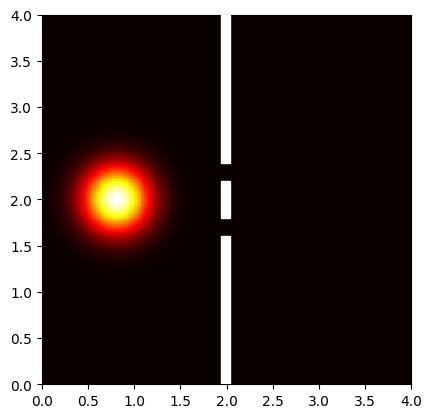

In [ ]:
# Parameters for simulation.
L  = 4
Dy = 0.02
Nt = 500
mul_fac = 0.3
x0 = L/5
y0 = L/2
sigma = L/16
k = 15*pi

# Build Helper Classes
grid = Grid(L, Dy, mul_fac, Nt)
particle = Particle(x0, y0, sigma, k)
slit_config = DoubleSlitConfiguration (L, Dy, False)
plotter = Plotter(L, Dy, slit_config)

# Plot Initial Condition
simulator = DoubleSlitADI(grid, particle, slit_config)
initial_condition = simulator.initial_condition()
img = plotter.plot_initial_condition(initial_condition)

In [ ]:
# Run the simulation
psis, mod_psis = simulator.simulate(True)

Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Iteration: 300
Iteration: 350
Iteration: 400
Iteration: 450


In [ ]:
# Animation logic
def update (frame):
    img.set_data(mod_psis[frame])
    img.set_zorder(1)

    return img

Nt = grid.Nt
anim = FuncAnimation(plotter.fig, update, interval=30,
                     frames=np.arange(0,Nt,2), repeat=False, blit=0)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

### Crank-Nicolson Method

The Crank-Nicolson (CN) Method solves the Schrodinger equation by discretizing the equation using a second-order accuracte centered difference for the second derivative w.r.t space and a Euler difference for the time derivative. Due to the nature of Taylor expansions, we get a **Second-Order** accurate scheme in both space and time. This reduces the restriction on the choice of time-step $\Delta t$.

In [ ]:
class DoubleSlitCN(Solver):

    def __init__ (self, grid, particle, slit_configuration,
                  potential = None, iteration_capture = 1):
        super().__init__(grid, particle, slit_configuration, potential)
        self.iteration_capture = iteration_capture

    '''
    This function sparisfies the potential matrix input by the
    user. This is used to make the calculations faster.
    '''
    def build_V(self):
        vals = list(np.concatenate(self.V[1:-1,1:-1]).flat)
        return sp.sparse.diags(vals)

    '''
    This function builds the 2 matrices that discretizes the
    Schrodinger equation according to the Crank-Nicolson method
    The system solves the equation

            A psi_{n+1} = M psi_n

    A = (a_{ij}) where
        a_{ij} =
            1 + 2*rx + 2*ry + V[i,j], main diagonal
                                 -ry, lower and upper lone diagonal
                                  rx, lower and upper main diagonal

    M = (m_{ij}) where
        m_{ij} =
            1 - 2*rx - 2*ry - V[i,j], main diagonal
                                  ry, lower and upper lone diagonal
                                 -rx, lower and upper main diagonal

    where,

    rx = -Dt/(2j*Dx**2)
    ry = -Dt/(2j*Dy**2)

    but we have Dx = Dy therefore,  rx = ry

    For infinite potential case, we have V[i, j] = 0
    '''
    def build_system_matrices(self):
        grid = self.grid
        sfac = (1j*(grid.Dt))/2
        hfac = (grid.Dt)/(2j*(grid.Dy**2))
        n    = grid.Nx-2
        nn   = n*n

        A_main_diag = [(1+4*hfac) for i in range (nn)]
        A_lone_diag = [-hfac for i in range (nn-n)]
        A_off_diag  = [hfac for i in range (nn-1)]

        M_main_diag = [(1-4*hfac) for i in range (nn)]
        M_lone_diag = [hfac for i in range (nn-n)]
        M_off_diag  = [-hfac for i in range (nn-1)]

        A_inf_pot   = sp.sparse.diags([A_main_diag, A_off_diag,
                                       A_off_diag, A_lone_diag,
                                       A_lone_diag],
                                      [0, 1, -1, n, -n],
                                      format='csc',
                                      dtype = complex)

        M_inf_pot   = sp.sparse.diags([M_main_diag, M_off_diag,
                                       M_off_diag, M_lone_diag,
                                       M_lone_diag],
                                      [0, 1, -1, n, -n],
                                      format='csc',
                                      dtype = complex)

        if self.finite_potential is True:
            V = (sfac) * self.build_V()
            return A_inf_pot + V, M_inf_pot - V

        return A_inf_pot, M_inf_pot

    '''
    This function computes the time evolution of the wavefunction
    using the CN method.
            psi            - wave function
            print_progress - Print the progress of the simulation
    '''
    def time_evolution(self, psis, print_progress):
        grid = self.grid
        A, M = self.build_system_matrices()
        psi  = psis[0]

        for i in range (1, grid.Nt):

            # Time Step
            psi_n = psi.reshape(grid.Ni)
            Mpsi_n = M.dot(psi_n)
            psi_np1 = sp.sparse.linalg.spsolve(A, Mpsi_n)
            psi = psi_np1.reshape((grid.Nx-2), (grid.Nx-2))

            # Boundary Conditions
            if self.finite_potential is False:
                psi = self.boundary_condition_at_slits(psi)
            psi = self.boundary_condition_at_walls(psi)

            if (i % self.iteration_capture == 0):
                psis.append(np.copy(psi))
            if (i % 50==0 and print_progress == True):
                print ("Iteration: %d" %(i))

    '''
    This function runs the simulation by creating an (X,Y) grid
    of points based on the grid configuration passed to the
    constructor. Returns the tracked wave function, and it's
    magnitude if it is not a reference run.

            psi            - wave function
            print_progress - Print the progress of the simulation
    '''
    def simulate(self, print_progress):

        psis = self.initialize_system()
        self.time_evolution(psis, print_progress)

        mod_psis = []
        for wavefunc in psis:
            mod_psis.append(np.abs(wavefunc))

        return psis, mod_psis

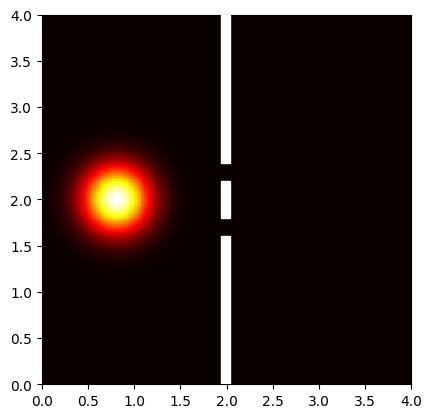

In [ ]:
# Parameters for simulation.
L  = 4
Dy = 0.02
mul_fac = 0.3
x0 = L/5
y0 = L/2
sigma = L/16
k = 15*pi

# Build Helper Classes
grid = Grid(L, Dy, mul_fac)
particle = Particle(x0, y0, sigma, k)
slit_config = DoubleSlitConfiguration (L, Dy, False)
plotter = Plotter(L, Dy, slit_config)

# Plot Initial Condition
simulator = DoubleSlitCN(grid, particle, slit_config)
initial_condition = simulator.initial_condition()
img = plotter.plot_initial_condition(initial_condition)

In [ ]:
# Run the simulation
psis, mod_psis = simulator.simulate(True)

Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Iteration: 300
Iteration: 350
Iteration: 400
Iteration: 450


In [ ]:
# Animation logic
def update (frame):
    img.set_data(mod_psis[frame])
    img.set_zorder(1)

    return img

Nt = grid.Nt
anim = FuncAnimation(plotter.fig, update, interval=30,
                     frames=np.arange(0,Nt,2), repeat=False, blit=0)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

### Spectral Methods

Fourier Spectral methods aim to capture the solution using a basis of sine and cosine waves. Here we have used **Fourth-order accurate Runge-Kutta** method to compute the timestep, while using Fourier methods to calculate the second derivative of the wave function w.r.t $x$ and $y$. The spectral methods are senstive to boundary condtions, and yet we are able to capture the fringe pattern on the screen effectively using Spectral methods. A closer mathematical analysis needs to be made to comment on the accuracy of the overall scheme given the discontinuous nature of the boundary conditions.

In [ ]:
class DoubleSlitSpectral(Solver):

    def __init__ (self, grid, particle, slit_configuration,
                  potential = None):
        super().__init__(grid, particle, slit_configuration, potential)
        self.iteration_capture = int((self.grid.Nt)/500)

    '''
    This function calculates the RHS of the Schrodinger equation, i.e
        psi_t = i (Dxx + Dyy) psi =  f(psi)
    '''
    def laplacian(self, psi):
        grid    = self.grid
        psi_fft = np.fft.fft2(psi)
        kx      = np.fft.fftfreq(grid.Nx-2, grid.Dy) * 2 * pi
        ky      = np.fft.fftfreq(grid.Nx-2, grid.Dy) * 2 * pi
        KX, KY  = np.meshgrid(kx, ky)

        laplacian_fft = -(KX**2 + KY**2) * psi_fft
        laplacian = 1j * np.fft.ifft2(laplacian_fft)
        return laplacian

    '''
    This function calculates the next time step of the solution
    by using the fourth order accurate Runge-Kutta method with
    '''
    def RK4_timestep(self, psi):
        Dt = self.grid.Dt
        k1 = Dt * self.laplacian(psi)
        k2 = Dt * self.laplacian(psi + (k1/2))
        k3 = Dt * self.laplacian(psi + (k2/2))
        k4 = Dt * self.laplacian(psi + k3)

        psi_np1 = psi + (k1 + (2*k2) + (2*k3) + k4)/6
        return psi_np1

    '''
    This function computes the time evolution of the wavefunction
    using the Fourier Spectral method.
            psi            - wave function
            print_progress - Print the progress of the simulation
    '''
    def time_evolution(self, psis, print_progress):
        grid  = self.grid
        psi   = psis[0]
        itcap = self.iteration_capture

        for i in range (1, grid.Nt):

            # Time Step
            psi_np1 = self.RK4_timestep(psi)

            # Boundary Conditions
            psi_np1 = self.boundary_condition_at_slits(psi_np1)
            psi_np1 = self.boundary_condition_at_walls(psi_np1)

            if (i % itcap == 0):
                psis.append(np.copy(psi_np1))
            if (i % (itcap * 50) == 0 and print_progress is True):
                print ("Iteration: %d" %(i))

            psi = psi_np1

    '''
    This function runs the simulation by creating an (X,Y) grid
    of points based on the grid configuration passed to the
    constructor. Returns the tracked wave function, and it's
    magnitude if it is not a reference run.

            psi            - wave function
            print_progress - Print the progress of the simulation
    '''
    def simulate(self, print_progress):

        psis = self.initialize_system()
        self.time_evolution(psis, print_progress)

        mod_psis = []
        for wavefunc in psis:
            mod_psis.append(np.abs(wavefunc))

        return psis, mod_psis

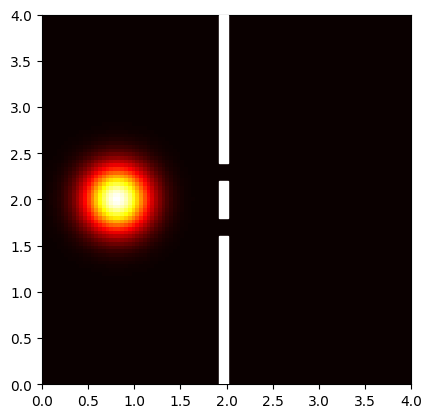

In [ ]:
L  = 4
Dy = 0.04
x0 = L/5
y0 = L/2
sigma = L/16
k = 30*pi

# Build Helper Classes
grid = Grid(L, Dy, spectral = True)
particle = Particle(x0, y0, sigma, k)
slit_config = DoubleSlitConfiguration (L, Dy, False)
plotter = Plotter(L, Dy, slit_config)

# Plot Initial Condition
simulator = DoubleSlitSpectral(grid, particle, slit_config)
initial_condition = simulator.initial_condition()
img = plotter.plot_initial_condition(initial_condition)

In [ ]:
# Run the simulation
psis, mod_psis = simulator.simulate(True)

Iteration: 1250
Iteration: 2500
Iteration: 3750
Iteration: 5000
Iteration: 6250
Iteration: 7500
Iteration: 8750
Iteration: 10000
Iteration: 11250
Iteration: 12500


In [ ]:
# Animation logic
def update (frame):
    img.set_data(mod_psis[frame])
    img.set_zorder(1)

    return img

anim = FuncAnimation(plotter.fig, update, interval=30,
                     frames=np.arange(0,500,2), repeat=False, blit=0)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()